# Real or Not? NLP with Disaster Tweets
## Выполнил Изотов Илья РИМ-191219

## 1. Подготовка

In [1]:
## Установка дополнительных пакетов для Jupyter Notebook (anaconda)
#!pip install --user -U nltk
#import nltk
#nltk.download()
#!pip install -U gensim
#!pip install -U keras
#!pip install -U tensorflow
#!pip install -U xgboost

In [2]:
import matplotlib.pyplot as plt # Графики наши графики
import seaborn as sns # Красивые наши графики
import pandas as pd # Работа с данными
import numpy as np # Матрицы
from nltk.corpus import stopwords # Понадобится для фильтрации стоп-слов
from collections import defaultdict # Работа со словарем 
import re # Регулярные выражения
import gensim # Библиотека обработки естественного языка
import string # Для обработки строк
from keras.layers import Embedding 
from sklearn.model_selection import train_test_split # Библиотека для разделения данных на выборки

plt.style.use('ggplot')
stop=set(stopwords.words('english'))

Using TensorFlow backend.


## 2. Загрузка данных

In [3]:
tweet_train= pd.read_csv('../input/nlp-getting-started/train.csv') # Исходные данные
test= pd.read_csv('../input/nlp-getting-started/test.csv') # Контрольные данные
tweet_all = pd.read_csv("../input/disasters-on-social-media/socialmedia-disaster-tweets-DFE.csv") # Исходные+тестовые данные с правильными ответами (полные данные)

### Подготовка набора со всеми данными к нужному виду

In [4]:
tweet_all = tweet_all[['choose_one', 'text', 'location', 'keyword']]
tweet_all["target"] = (tweet_all['choose_one']=="Relevant").astype(int)
tweet_all['id'] = tweet_all.index
tweet_all = tweet_all[['id', 'location', 'keyword', 'text', 'target']]
tweet_all

,id,location,keyword,text,target
0,0,NaN,NaN,Just happened a terrible car crash,1
1,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
2,2,NaN,NaN,"Heard about #earthquake is different cities, s...",1
3,3,NaN,NaN,"there is a forest fire at spot pond, geese are...",1
4,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
...,...,...,...,...,...
10871,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
10872,10872,NaN,NaN,Police investigating after an e-bike collided ...,1
10873,10873,NaN,NaN,The Latest: More Homes Razed by Northern Calif...,1
10874,10874,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) htt...,1


In [5]:
tweet_all[tweet_all['target']==1]['text'].values[0]

'Just happened a terrible car crash'

In [6]:
tweet_all.head(10)

,id,location,keyword,text,target
0,0,NaN,NaN,Just happened a terrible car crash,1
1,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
2,2,NaN,NaN,"Heard about #earthquake is different cities, s...",1
3,3,NaN,NaN,"there is a forest fire at spot pond, geese are...",1
4,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
5,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
6,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
7,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
8,8,NaN,NaN,#RockyFire Update => California Hwy. 20 closed...,1
9,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires,1


## 3. Исследование данных

### Сравнение исходных и полных данных

In [7]:
print(tweet_all.shape, tweet_train.shape) # Размеры полных данных и исходных данных соответственно

(10876, 5) (7613, 5)


In [8]:
x=tweet_all.target.value_counts()
y=tweet_train.target.value_counts()

In [9]:
print(x,'\n', y)
print(x[0]/(x[0]+x[1]))
print(y[0]/(y[0]+y[1]))
# Соотношения твитов в выборках одинаковое

0    6203
1    4673
Name: target, dtype: int64 
 0    4342
1    3271
Name: target, dtype: int64
0.570338359691063
0.5703402075397347


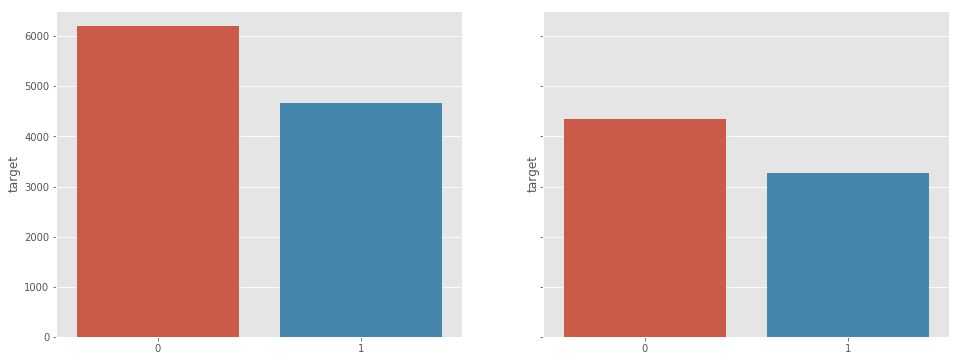

In [10]:
_, axes = plt.subplots(1, 2, sharey=True, figsize=(16,6))
sns.barplot(x.index,x, ax=axes[0])
sns.barplot(y.index,y, ax=axes[1])

### Количество слов в сообщениях

In [11]:
tweet = tweet_all
y = tweet[tweet['target']==1]['text'].str.split()
print(y)

0                [Just, happened, a, terrible, car, crash]
1        [Our, Deeds, are, the, Reason, of, this, #eart...
2        [Heard, about, #earthquake, is, different, cit...
3        [there, is, a, forest, fire, at, spot, pond,, ...
4           [Forest, fire, near, La, Ronge, Sask., Canada]
                               ...                        
10871    [M1.94, [01:04, UTC]?5km, S, of, Volcano, Hawa...
10872    [Police, investigating, after, an, e-bike, col...
10873    [The, Latest:, More, Homes, Razed, by, Norther...
10874    [MEG, issues, Hazardous, Weather, Outlook, (HW...
10875    [#CityofCalgary, has, activated, its, Municipa...
Name: text, Length: 4673, dtype: object


(array([  27.,  171.,  505.,  798.,  880., 1001.,  764.,  377.,  134.,
          16.]),
 array([ 1. ,  3.9,  6.8,  9.7, 12.6, 15.5, 18.4, 21.3, 24.2, 27.1, 30. ]),
 <a list of 10 Patch objects>)

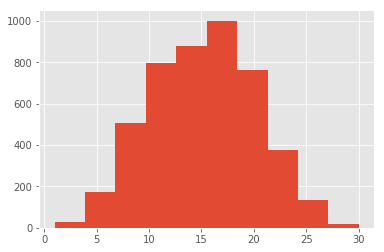

In [12]:
word_len_true=tweet[tweet['target']==1]['text'].str.split().str.len() 
plt.hist(word_len_true) # Распределение тревожных сообщений по количеству слов

(array([ 150.,  482.,  762.,  987.,  982., 1042.,  853.,  577.,  292.,
          76.]),
 array([ 1.,  4.,  7., 10., 13., 16., 19., 22., 25., 28., 31.]),
 <a list of 10 Patch objects>)

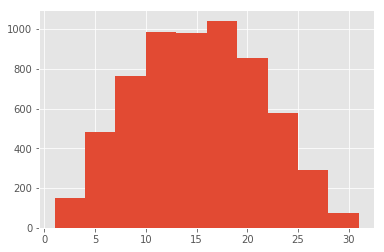

In [13]:
word_len_false=tweet[tweet['target']==0]['text'].str.split().str.len()
plt.hist(word_len_false) # Распределение нетревожных сообщений по количеству слов

### Исследовние частотности слов

In [14]:
def create_corpus(target):
    corpus= []
    
    for l in y:
        for q in l:
            corpus.append(q)
    return(corpus)

In [15]:
corpus= create_corpus(1)
corpus[0:10]

['Just',
 'happened',
 'a',
 'terrible',
 'car',
 'crash',
 'Our',
 'Deeds',
 'are',
 'the']

<BarContainer object of 10 artists>

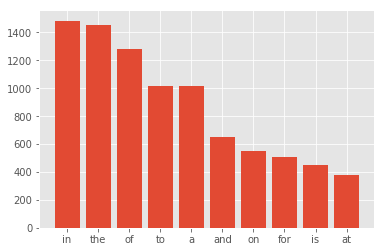

In [16]:
dic = defaultdict(int)

for i in corpus:
    if i in stop:
        dic[i]= dic[i]+1
top = sorted(dic.items(), key= lambda x: x[1], reverse= True)[:10]
m,n = zip(*top)
plt.bar(m,n)

## 4. Чистка данных

In [17]:
def sterilization(data):
    
    data = re.sub('https?://\S+|www\.\S+', '', data)
    data = re.sub('<.*?>', '', data)
    emoj = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    emoj.sub(r'', data)
    data = data.lower()
    data = data.translate(str.maketrans('','', string.punctuation))
    data = re.sub(r'\[.*?\]', '', data)
    data = re.sub(r'\w*\d\w*','', data)
    data = ' '.join([w for w in data.split() if w not in stop])
  
    return data
    
    

In [18]:
df = tweet.copy()
df['text']=tweet['text'].apply(lambda x : sterilization(x))
df.head(10)


,id,location,keyword,text,target
0,0,NaN,NaN,happened terrible car crash,1
1,1,NaN,NaN,deeds reason earthquake may allah forgive us,1
2,2,NaN,NaN,heard earthquake different cities stay safe ev...,1
3,3,NaN,NaN,forest fire spot pond geese fleeing across str...,1
4,4,NaN,NaN,forest fire near la ronge sask canada,1
5,5,NaN,NaN,residents asked shelter place notified officer...,1
6,6,NaN,NaN,people receive wildfires evacuation orders cal...,1
7,7,NaN,NaN,got sent photo ruby alaska smoke wildfires pou...,1
8,8,NaN,NaN,rockyfire update california hwy closed directi...,1
9,9,NaN,NaN,apocalypse lighting spokane wildfires,1


### Подготовка данных для Word2Vec

In [19]:
from nltk.tokenize import RegexpTokenizer

tokenizer = RegexpTokenizer(r'\w+')

df["tokens"] = df["text"].apply(tokenizer.tokenize)
df.head()

,id,location,keyword,text,target,tokens
0,0,NaN,NaN,happened terrible car crash,1,"[happened, terrible, car, crash]"
1,1,NaN,NaN,deeds reason earthquake may allah forgive us,1,"[deeds, reason, earthquake, may, allah, forgiv..."
2,2,NaN,NaN,heard earthquake different cities stay safe ev...,1,"[heard, earthquake, different, cities, stay, s..."
3,3,NaN,NaN,forest fire spot pond geese fleeing across str...,1,"[forest, fire, spot, pond, geese, fleeing, acr..."
4,4,NaN,NaN,forest fire near la ronge sask canada,1,"[forest, fire, near, la, ronge, sask, canada]"


## 5. Word2Vec 

### Загрузка предтренированной модели Word2Vec от Google

In [20]:
word2vec_path = "../input/googles-trained-word2vec-model-in-python/GoogleNews-vectors-negative300.bin"
word2vec = gensim.models.KeyedVectors.load_word2vec_format(word2vec_path, binary=True)

### Взятие среднего из всех векторных весов слов, присутствующих в одном твите

In [21]:
def get_average_word2vec(tokens_list, vector, generate_missing=False, k=300):
    if len(tokens_list)<1:
        return np.zeros(k)
    if generate_missing:
        vectorized = [vector[word] if word in vector else np.random.rand(k) for word in tokens_list]
    else:
        vectorized = [vector[word] if word in vector else np.zeros(k) for word in tokens_list]
   
    length = len(vectorized)
    summed = np.sum(vectorized, axis=0)
    averaged = np.divide(summed, length)
    return averaged

def get_word2vec_embeddings(vectors, df, generate_missing=False):
    embeddings = df.apply(lambda x: get_average_word2vec(x, vectors, generate_missing=generate_missing))
    return list(embeddings)

In [22]:
tweet.shape

(10876, 5)

In [23]:
X_train= df['tokens']
y_train= df['target']

In [24]:
embeddings = get_word2vec_embeddings(word2vec, X_train)

### Деление данных на выборки

In [25]:
X_train_word2vec, X_test_word2vec, y_train_word2vec, y_test_word2vec = train_test_split(embeddings, y_train, test_size= 0.14, random_state=50)

## 6. Проверка предсказаний с использованием логистической регрессии

In [26]:
from sklearn.linear_model import LogisticRegression
clf_w2v = LogisticRegression(C=30.0, class_weight='balanced', solver='newton-cg', 
                         multi_class='multinomial', random_state=40)
clf_w2v.fit(X_train_word2vec, y_train_word2vec)
y_predicted_word2vec = clf_w2v.predict(X_test_word2vec)

In [27]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report

def get_metrics(y_test, y_predicted):  
    # true positives / (true positives+false positives)
    precision = precision_score(y_test, y_predicted, pos_label=None,
                                    average='weighted')             
    # true positives / (true positives + false negatives)
    recall = recall_score(y_test, y_predicted, pos_label=None,
                              average='weighted')
    
    # harmonic mean of precision and recall
    f1 = f1_score(y_test, y_predicted, pos_label=None, average='weighted')
    
    # true positives + true negatives/ total
    accuracy = accuracy_score(y_test, y_predicted)
    return accuracy, precision, recall, f1

accuracy_word2vec, precision_word2vec, recall_word2vec, f1_word2vec = get_metrics(y_test_word2vec, y_predicted_word2vec)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy_word2vec, precision_word2vec, 
                                                                       recall_word2vec, f1_word2vec))

accuracy = 0.811, precision = 0.810, recall = 0.811, f1 = 0.810


### Подготовка тестовых данных для предсказаний и последующего сабмита 

In [28]:
X_test = test.copy()
X_test['text']=X_test['text'].apply(lambda x : sterilization(x))
tokenizer = RegexpTokenizer(r'\w+')
X_test["tokens"] = X_test["text"].apply(tokenizer.tokenize)
X_test = X_test["tokens"]
test_embeds = get_word2vec_embeddings(word2vec, X_test)

In [29]:
submission = pd.read_csv("../input/nlp-getting-started/sample_submission.csv")

submission["target"] = clf_w2v.predict(test_embeds)
submission["target"] = submission["target"].apply(lambda x: int(x))
#print(submission.head())
submission.to_csv("submission.csv", index=False)

## Проверка предсказаний с использованием классификатора XBoost

In [30]:
from xgboost import XGBClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import f1_score
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline

In [31]:
clf = XGBClassifier(colsample_bytree=0.8, learning_rate= 0.05, max_depth= 10,
                    min_child_weight=11, missing= -999, n_estimators= 1200,
                    nthread= 4, objective='binary:logistic', seed=1337, silent=1, subsample=0.8)

In [32]:
XTa= np.array(X_train_word2vec)
yTa= np.array(y_train_word2vec)

### Тренировка сети

In [33]:
clf.fit(XTa,yTa)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.05, max_delta_step=0, max_depth=10,
              min_child_weight=11, missing=-999, monotone_constraints=None,
              n_estimators=1200, n_jobs=4, nthread=4, num_parallel_tree=1,
              objective='binary:logistic', random_state=1337, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, seed=1337, silent=1,
              subsample=0.8, tree_method=None, validate_parameters=False,
              verbosity=None)

In [34]:
y_predicted_word2vec = clf.predict(np.array(X_test_word2vec))
y_predicted_word2vec

array([0, 0, 0, ..., 1, 0, 0])

In [35]:
accuracy_word2vec, precision_word2vec, recall_word2vec, f1_word2vec = get_metrics(y_test_word2vec, y_predicted_word2vec)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy_word2vec, precision_word2vec, 
                                                                       recall_word2vec, f1_word2vec))

accuracy = 0.831, precision = 0.832, recall = 0.831, f1 = 0.829


In [36]:
submission["target"] = clf.predict(np.array(test_embeds))
submission["target"] = submission["target"].apply(lambda x: int(x))
#print(submission.head())
submission.to_csv("submission.csv", index=False)